# Lib

In [1]:
# IMPORT ALL LIB 
import subprocess
import numpy as np  
import matplotlib.pyplot as plt 
import os
import json
import time


#%pip install pyvisa
#%pip install pyvisa-py
import pyvisa  
print("pyvisa==",pyvisa.__version__)


# EMI reciver
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

pyvisa== 1.15.0


# Utils

## Scope

In [2]:
def my_ip():
    # The IP of the PC 
    result = subprocess.run(["ipconfig"], capture_output=True, text=True)
    output =result.stdout
    arr=output.split("\n")
    for i,l in enumerate (arr):
        if "Ethernet adapter Ethernet:" in l:
            break
    for j in range(i,i+7):
        l= arr[j]
        if "Link-local IPv6 Address . . . . . :" in l:
            continue 
        print(l)

In [3]:
def ping_oscilloscope(ip="169.254.229.238", count=1):
    try:
        result = subprocess.run(
            ["ping", "-n", str(count), ip],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,  # decode output as text
            shell=True
        )
        if result.returncode == 0:
            print("Ping successful:")
        else:
            print("Ping failed:")
        print(result.stdout)
    except Exception as e:
        print("Error pinging oscilloscope:", e)

In [4]:
def connect_to_scope(scope_ip):
    rm = pyvisa.ResourceManager('@py') # Use pyvisa-py backend  
    
     
    resource_str = f"TCPIP::{scope_ip}::INSTR"  
    try:  
        scope.close()  
    except: pass  
    try:  
        scope = rm.open_resource(resource_str)  
        return scope
        print("Connected to:", scope.query("*IDN?"))  
    except Exception as e:  
        print("Connection failed:", e)  

In [5]:
def get_config():
    t_div = float(scope.query("HORIZONTAL:MAIN:SCALE?"))   
    v_div = float(scope.query("CH1:SCALE?"))   
    n_pts = int(scope.query("WFMPRE:NR_Pt?"))  

    impedance = scope.query("CH1:IMP?").strip()

    data_width = scope.query("DATA:WIDTH?").strip()
 
    if "FIFTY" in impedance.upper(): 
        Z= 50
    else: 
        Z=1e6
    Ts= 10*t_div/n_pts
    dic = {"t_div":t_div,
            "Ts":Ts,
            "v_div":v_div , 
            "n_pts": n_pts , 
            "Z": Z, 
            "channel": "CH1", 
            "bytesPeSample":data_width,
           "date_time":time.strftime("%Y_%m_%d_%H_%M")
          }

    return dic


In [6]:
def Data_config():

    FIRST_TIME= False 
    scope.write("DATA:SOURCE CH1")  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000") 

In [7]:
def get_data_raw():

    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # Depending on your scope: True → MSB first, False → LSB first
    container=np.array , # default dtype='>i2' mean big-endian signed 16-bit integer
    )  
    return raw

In [8]:
def finNbBits(raw):
    #nbBits = 
    for i in range(16,0,-1):
        y = raw/2**i
        if np.abs(y-y.round()).max()==0:
            return 16-i
    # I test this function i get 9, so nb = 9 as datasheet 

In [9]:
def tran_sampling(N = 10, nbpoints = 10000):
    arr = np.zeros((N, nbpoints), dtype='>i2')
    for i in range(N):
        raw = get_data_raw()
        arr[i] = raw
    arr = arr.flatten()
    return arr

In [10]:
def raw_to_volte(raw, dicConfig ,nbbits=9):
    resH=dicConfig ['v_div']
    div= 16-nbbits
    y = raw/(2**div)
    y = y/(int(1/float(resH))*5) # 5 in positive 5 in negative
    y =   y .astype("float32")
    return y

## EMI RECIVER 

### FFT

In [11]:
def voltage_to_dBuV_spectrum(arr, Ts):
    """
    Compute the single-sided voltage spectrum of arr (in volts),
    and convert to dBµV (decibels relative to 1 µV).
    
    Returns:
        freqs: numpy array of frequency bins (Hz)
        spectrum_dBuV: numpy array of magnitudes in dBµV
    """
    N = len(arr)
    # FFT
    Y = rfft(arr)
    # Frequency bins
    freqs = rfftfreq(N, Ts)
    
    # Compute amplitude spectrum (peak)
    # Norm: divide by N so that the amplitude reflects actual signal amplitude
    # Because rfft gives only half spectrum, multiply non-DC components by 2
    # e.g. see many DSP references
    
    # Magnitude (absolute)
    mag = np.abs(Y) / N
    # multiply by 2 (for single-sided), except DC component at index 0
    mag[1:] = mag[1:] * 2

    # Convert volts → microvolts
    mag_uV = mag * 1e6  # now in µV

    # avoid log of zero
    #eps = 1e-20
    spectrum_dBuV = 20 * np.log10(mag_uV )
    
    return freqs, spectrum_dBuV

### Gaussian 9 kHz RBW instead of boxcar

In [12]:

# ---------- Helpers ----------

def _next_pow2(n):
    # next power of two >= n
    return 1 << (int(n - 1).bit_length())

def _choose_nfft(fs, rbw_hz, oversample=5, max_nfft=1 << 18):
    """
    Pick NFFT so that Δf = fs/NFFT <= RBW/oversample, limited to max_nfft.
    """
    target_df = rbw_hz / float(oversample)
    nfft = int(np.ceil(fs / target_df))
    nfft = _next_pow2(max(1024, nfft))
    return min(nfft, max_nfft)

def _one_sided_psd(frame, fs, window):
    """
    Periodogram with window power normalization, one-sided doubling.
    PSD units: V^2/Hz. Shape: (N/2+1,)
    """
    N = len(frame)
    U = np.mean(window**2)  # window power
    X = rfft(frame * window)
    psd = (np.abs(X)**2) / (fs * N * U)  # two-sided to start
    # One-sided doubling (except DC and Nyquist for even N)
    if N % 2 == 0:
        psd[1:-1] *= 2.0
    else:
        psd[1:] *= 2.0
    return psd
def _quasi_peak(envelope, dt, tau_c, tau_d, return_mode="max"):
    """
    Quasi-peak detector on a non-negative envelope (e.g., Vrms in RBW per frame).
    Attack (charge) with tau_c, decay (discharge) with tau_d.
    Return either the max detector output over time or the final value.
    """
    y = 0.0
    out = np.empty_like(envelope)
    a_c = np.exp(-dt / tau_c)
    a_d = np.exp(-dt / tau_d)
    for i, x in enumerate(envelope):
        if x >= y:
            y = a_c * y + (1 - a_c) * x
        else:
            y = a_d * y + (1 - a_d) * x
        out[i] = y
    return out.max() if return_mode == "max" else out[-1]

def _gaussian_rbw_kernel(df, rbw_hz, span_sigmas=5):
    """
    Build |H(f)|^2 kernel approximating CISPR quasi-Gaussian RBW.

    We choose a Gaussian AMPLITUDE response H(f) with –6 dB amplitude at ±RBW/2.
    For Gaussian amplitude: H(f) = exp(-(f^2)/(2σ^2)).
      –6 dB amplitude point: |H(f6)| = 10^(-6/20) ≈ 0.501187.
      => f6 = σ * sqrt(2 ln(1/0.501187)) ≈ 1.176 σ  ⇒ σ ≈ (RBW/2)/1.176.
    We convolve PSD with |H|^2, then multiply by Δf to approximate ∫ PSD·|H|^2 df.
    """
    f6 = rbw_hz / 2.0
    sigma = f6 / 1.176  # ≈ RBW / 2.352

    # Discretize kernel over ±span_sigmas·σ
    half_span_hz = span_sigmas * sigma
    half_bins = int(np.ceil(half_span_hz / df))
    offs = (np.arange(-half_bins, half_bins + 1) * df)
    H_amp = np.exp(-0.5 * (offs / sigma) ** 2)   # amplitude response
    kernel_power = H_amp ** 2                    # |H|^2 for power integration
    return kernel_power

# ---------- Main function ----------
def emi_detectors_rbw2(arr, Ts, rbw_hz=9e3, window_name='hann',
                      nfft=None, overlap=0.75,
                      qp_band='B', qp_return='max',
                      rbw_shape='gaussian', span_sigmas=5):
    """
    Compute Peak / Average / Quasi-Peak in dBµV for RBW integration.

    Parameters
    ----------
    arr : 1D np.ndarray
        Time-domain signal in Volts.
    Ts : float
        Sampling period in seconds.
    rbw_hz : float
        Resolution bandwidth (Hz). Default 9 kHz.
    window_name : {'hann','rect'}
        STFT analysis window (leakage control; not the IF filter).
    nfft : int or None
        FFT size per frame. If None, chosen automatically vs RBW.
    overlap : float in [0,1)
        Frame overlap fraction.
    qp_band : {'A','B','C','D'}
        CISPR band for QP time constants:
        - A: 9–150 kHz → RBW 200 Hz, τc=45 ms, τd=500 ms
        - B: 150 kHz–30 MHz → RBW 9 kHz, τc=1 ms, τd=160 ms (default)
        - C/D: ≥30 MHz → RBW 120 kHz, τc=1 ms, τd=550 ms
    qp_return : {'max','final'}
        Return max or final quasi-peak output along time.
    rbw_shape : {'gaussian','rect'}
        RBW integration kernel in frequency. 'gaussian' approximates CISPR IF.
    span_sigmas : int
        Width of Gaussian kernel in ±σ units (only used for 'gaussian').

    Returns
    -------
    freqs : 1D array (Hz)
    dBuV_peak : 1D array
    dBuV_avg  : 1D array
    dBuV_qp   : 1D array
    """

    fs = 1.0 / Ts
    x = np.asarray(arr, dtype=float)
    Nsig = len(x)

    # Analysis window (for PSD leakage control)
    if window_name == 'hann':
        win_fn = np.hanning
    elif window_name == 'rect':
        win_fn = np.ones
    else:
        raise ValueError("window_name must be 'hann' or 'rect'")

    # Pick NFFT if not provided
    if nfft is None:
        nfft = _choose_nfft(fs, rbw_hz, oversample=5)
    nfft = min(nfft, Nsig) if Nsig < nfft else nfft

    hop = max(1, int(nfft * (1.0 - overlap)))
    window = win_fn(nfft)

    # Frame indices
    starts = np.arange(0, Nsig - nfft + 1, hop, dtype=int)
    if len(starts) == 0:
        # zero-pad one frame
        pad = np.zeros(nfft, dtype=float)
        pad[:Nsig] = x
        frames = pad[None, :]
        starts = np.array([0])
    else:
        frames = np.lib.stride_tricks.as_strided(
            x, shape=(len(starts), nfft),
            strides=(x.strides[0]*hop, x.strides[0])
        ).copy()

    # PSD per frame (one-sided)
    psd_list = []
    for fr in frames:
        psd_list.append(_one_sided_psd(fr, fs, window))
    psd = np.vstack(psd_list)    # shape: (T, F)
    freqs = rfftfreq(nfft, Ts)
    df = fs / nfft

    # ----- RBW integration via kernel in frequency -----
    if rbw_shape == 'gaussian':
        ker = _gaussian_rbw_kernel(df, rbw_hz, span_sigmas=span_sigmas)
    elif rbw_shape == 'rect':
        bins_in_rbw = max(1, int(round(rbw_hz / df)))
        ker = np.ones(bins_in_rbw, dtype=float)
    else:
        raise ValueError("rbw_shape must be 'gaussian' or 'rect'")

    from numpy import convolve
    P_rbw = np.empty_like(psd)
    for t in range(psd.shape[0]):
        if rbw_shape == 'rect':
            psd_sum = np.convolve(psd[t], ker, mode='same')
            P_rbw[t] = psd_sum * df               # rectangular: sum * Δf
        else:
            # Gaussian: integrate PSD * |H|^2 over frequency
            psd_w = np.convolve(psd[t], ker, mode='same')
            P_rbw[t] = psd_w * df                 # ∑ PSD·|H|^2 · Δf ≈ ∫ PSD·|H|^2 df

    # Voltage RMS per time & frequency
    Vrms = np.sqrt(np.maximum(P_rbw, 0.0))  # shape (T, F)

    # Detectors along time
    Vrms_peak = Vrms.max(axis=0)    # Peak
    Vrms_avg  = Vrms.mean(axis=0)   # Average (linear)

    # Quasi-Peak constants per CISPR band
    if qp_band.upper() == 'A':
        tau_c, tau_d = 45e-3, 500e-3
    elif qp_band.upper() == 'B':
        tau_c, tau_d = 1e-3, 160e-3
    elif qp_band.upper() in ('C', 'D'):
        tau_c, tau_d = 1e-3, 550e-3
    else:
        raise ValueError("qp_band must be one of {'A','B','C','D'}")

    dt = hop / fs  # detector time step equals frame hop duration
    Vrms_qp = np.empty(Vrms.shape[1], dtype=float)
    for f_idx in range(Vrms.shape[1]):
        Vrms_qp[f_idx] = _quasi_peak(Vrms[:, f_idx], dt, tau_c, tau_d, return_mode=qp_return)

    # Convert to dBµV
    eps = 1e-15  # numerical floor to prevent log(0)
    dBuV_peak = 20.0 * np.log10(np.maximum(Vrms_peak, eps) * 1e6)
    dBuV_avg  = 20.0 * np.log10(np.maximum(Vrms_avg,  eps) * 1e6)
    dBuV_qp   = 20.0 * np.log10(np.maximum(Vrms_qp,   eps) * 1e6)

    return freqs, dBuV_peak, dBuV_avg, dBuV_qp

In [13]:
### Remove 10 KHZ oscillation

In [14]:
# max step = 5khz see 
# RBW of 9 kHz and a maximum step size of 5 kHz 
# https://www.ti.com/lit/eb/slyy208/slyy208.pdf
def remove_oscillation_10kHz(freqs , dBuV_qp, step = 2.5e3,fstart=150e3, fend=30e6, distance=2):
    """
    Removes small oscillations (~10 kHz) from quasi-peak spectrum data
    by extracting the peak envelope and interpolating it with a smooth curve.

    Parameters
    ----------
    freqs : ndarray
        Frequency array in Hz corresponding to the measurements.
    dBuV_qp : ndarray
        Quasi-peak detector amplitude values in dBµV.
    step : float, optional
        Frequency step in Hz for interpolation (default = 2.5 kHz).

    Returns
    -------
    newFreq : ndarray
        New frequency grid from 150 kHz to 30 MHz with given step.
    dbpeakinter : ndarray
        Interpolated envelope values (dBµV) corresponding to newFreq.
    """

    # Detect peaks with a tighter distance (actual peaks used in envelope construction)
    peaks, _ = find_peaks(dBuV_qp, distance=distance)

    # Extract amplitude values of detected peaks
    dbpeak = dBuV_qp[peaks]

    # Extract frequency positions of detected peaks
    freqpeak = freqs[peaks]

    # Define new frequency grid from 150 kHz to 30 MHz
    newFreq = np.arange(fstart, fend, step)

    # Interpolate envelope over the new frequency grid using cubic interpolation
    env_fun = interp1d(
        freqpeak, dbpeak, 
        kind='cubic', 
        bounds_error=False, 
        fill_value="extrapolate"
    )

    # Evaluate the interpolated envelope
    dbpeakinter = env_fun(newFreq)

    return newFreq, dbpeakinter


In [15]:
def EMI_emulator(arr, Ts, rbw_hz=9e3, window_name='hann',
                      nfft=None, overlap=0.75,
                      qp_band='B', qp_return='max',
                      rbw_shape='gaussian', span_sigmas=5, 
                 step = 2.5e3,fstart=150e3, fend=30e6, distance=2,
                detectors= ["peak", "avg","qpeak"]):
    freqs, dBuV_peak, dBuV_avg, dBuV_qp= emi_detectors_rbw2(arr=arr, Ts=Ts, rbw_hz=rbw_hz, window_name=window_name,
                          nfft=nfft, overlap=overlap,
                          qp_band=qp_band, qp_return=qp_return,
                          rbw_shape=rbw_shape, span_sigmas=span_sigmas)
    etherArr={"peak": dBuV_peak, "avg":dBuV_avg, "qpeak":dBuV_qp}
    
    dic_res = {}
    for det in detectors: 
        val = etherArr[det]
        newFreq,val2  = remove_oscillation_10kHz(freqs , val, step = step,
                                             fstart=fstart, fend=fend, distance=distance)
        dic_res[det]= val2
        
    dic_res["freq"]= newFreq
    return dic_res

# SCOPE conction 

In [37]:
my_ip()
scope_ip = "169.254.104.98" 
print("-"*50)
ping_oscilloscope(ip = scope_ip )
print("-"*50)
scope = connect_to_scope(scope_ip)

Ethernet adapter Ethernet:

   Connection-specific DNS Suffix  . : 
   Autoconfiguration IPv4 Address. . : 169.254.104.97
   Subnet Mask . . . . . . . . . . . : 255.255.0.0
   Default Gateway . . . . . . . . . : 
--------------------------------------------------
Ping successful:

Pinging 169.254.104.98 with 32 bytes of data:
Reply from 169.254.104.98: bytes=32 time=1ms TTL=255

Ping statistics for 169.254.104.98:
    Packets: Sent = 1, Received = 1, Lost = 0 (0% loss),
Approximate round trip times in milli-seconds:
    Minimum = 1ms, Maximum = 1ms, Average = 1ms

--------------------------------------------------


# TEST Num 1

## Get data 

In [100]:
testName="TriangWave120khz13mvPP"

In [101]:
try: 
    os.mkdir(testName)
    print(f"{testName} : created")
except: 
    print(f"{testName} : exist")

TriangWave120khz13mvPP : created


In [102]:
Data_config()

In [103]:
config=get_config()
configPath = testName+"/config"+".json"
with open(configPath, "w") as f:
    json.dump(config, f, indent=4)
with open(configPath, "r") as f:
    dic = json.load(f)
dic

{'t_div': 1e-05,
 'Ts': 1e-08,
 'v_div': 0.05,
 'n_pts': 10000,
 'Z': 50,
 'channel': 'CH1',
 'bytesPeSample': '2',
 'date_time': '2025_09_23_17_42'}

In [104]:
%%time
# RUN THE TEST  
arr= tran_sampling(N = 100)

CPU times: total: 31.2 ms
Wall time: 28.8 s


In [105]:
# Save data 
arrayPath = testName+"/np_data.npy"
# Save to .npy file
np.save(arrayPath , arr)

## Preprocessing

### Load saved data 

In [106]:
testName="TriangWave120khz13mvPP"

In [107]:
# load data 
arrayPath = testName+"/np_data.npy"
raw = np.load(arrayPath )
raw.shape, raw.dtype

((1000000,), dtype('>i2'))

In [108]:
configPath = testName+"/config"+".json"
with open(configPath, "r") as f:
    dicConfig = json.load(f)
Ts = dicConfig ["Ts"]
dicConfig 

{'t_div': 1e-05,
 'Ts': 1e-08,
 'v_div': 0.05,
 'n_pts': 10000,
 'Z': 50,
 'channel': 'CH1',
 'bytesPeSample': '2',
 'date_time': '2025_09_23_17_42'}

In [112]:
y = raw_to_volte(raw, dicConfig )

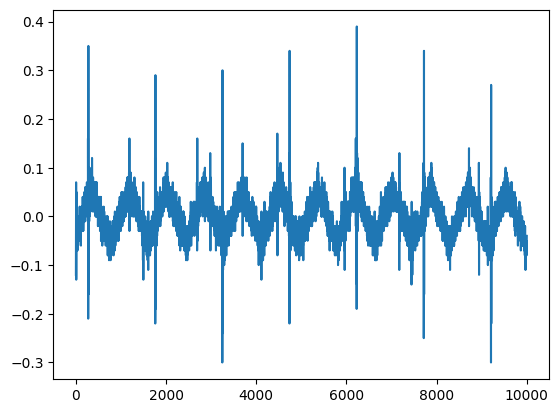

In [113]:
y = raw_to_volte(raw, dicConfig )
plt.plot(y[:len(y)//100:])

### EMI processing

In [114]:
%%time 
dic_res = EMI_emulator(arr=y, Ts=Ts, rbw_hz=9e3,  
                 step = 2.5e3,fstart=150e3, fend=30e6, 
                detectors= [ "avg","qpeak"])

CPU times: total: 1.72 s
Wall time: 2.9 s


In [115]:
freqs = dic_res['freq']
avg= dic_res['avg']
qpeak = dic_res['qpeak']

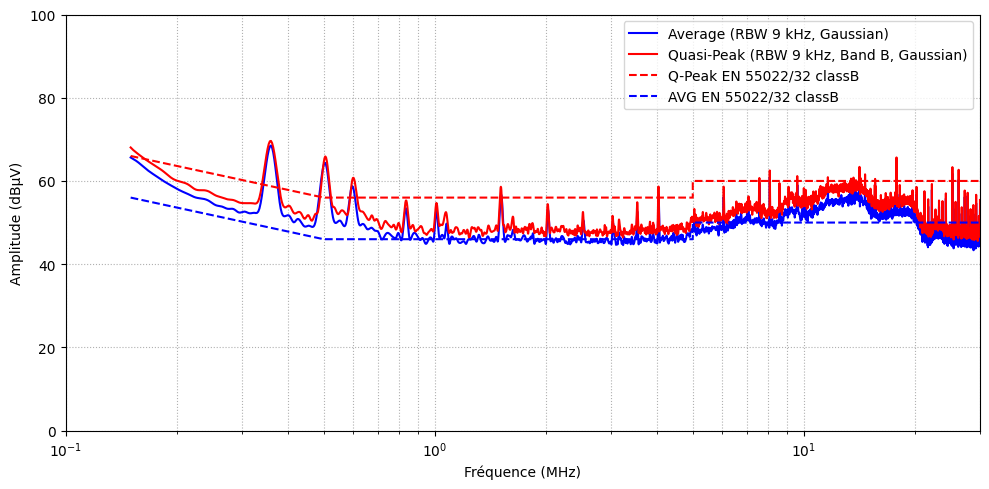

In [116]:
plt.figure(figsize=(10,5))


plt.semilogx(freqs*1e-6, avg,  label='Average (RBW 9 kHz, Gaussian)',c="b")
plt.semilogx(freqs*1e-6, qpeak,   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)',c="r")

# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Q-Peak EN 55022/32 classB', c="r",linestyle="--")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG EN 55022/32 classB', c= "b",linestyle="--")
plt.ylim([0,100])
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

# TEST Num 2

## Get data 

In [118]:
testName="TriangWave120khz13mvPP_V2"

In [119]:
try: 
    os.mkdir(testName)
    print(f"{testName} : created")
except: 
    print(f"{testName} : exist")

TriangWave120khz13mvPP_V2 : created


In [120]:
Data_config()

In [121]:
config=get_config()
configPath = testName+"/config"+".json"
with open(configPath, "w") as f:
    json.dump(config, f, indent=4)
with open(configPath, "r") as f:
    dic = json.load(f)
dic

{'t_div': 1e-05,
 'Ts': 1e-08,
 'v_div': 0.002,
 'n_pts': 10000,
 'Z': 50,
 'channel': 'CH1',
 'bytesPeSample': '2',
 'date_time': '2025_09_23_17_46'}

In [122]:
%%time
# RUN THE TEST  
arr= tran_sampling(N = 100)

CPU times: total: 93.8 ms
Wall time: 28.9 s


In [123]:
# Save data 
arrayPath = testName+"/np_data.npy"
# Save to .npy file
np.save(arrayPath , arr)

## Preprocessing

### Load saved data 

In [16]:
testName="TriangWave120khz13mvPP_V2"

In [17]:
# load data 
arrayPath = testName+"/np_data.npy"
raw = np.load(arrayPath )
raw.shape, raw.dtype

((1000000,), dtype('>i2'))

In [18]:
configPath = testName+"/config"+".json"
with open(configPath, "r") as f:
    dicConfig = json.load(f)
Ts = dicConfig ["Ts"]
dicConfig 

{'t_div': 1e-05,
 'Ts': 1e-08,
 'v_div': 0.002,
 'n_pts': 10000,
 'Z': 50,
 'channel': 'CH1',
 'bytesPeSample': '2',
 'date_time': '2025_09_23_17_46'}

In [19]:
y = raw_to_volte(raw, dicConfig )

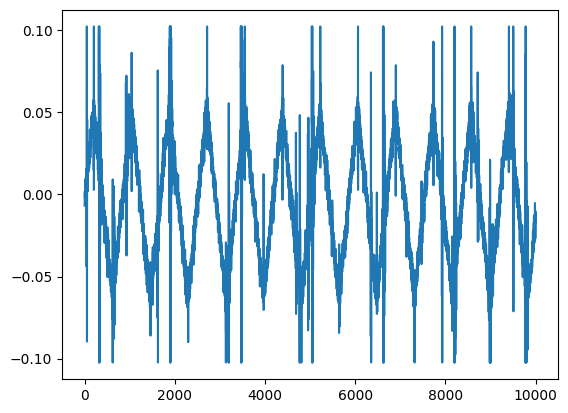

In [20]:
y = raw_to_volte(raw, dicConfig )
plt.plot(y[:len(y)//100:])

### EMI processing

In [21]:
%%time 
dic_res = EMI_emulator(arr=y, Ts=Ts, rbw_hz=9e3,  
                 step = 2.5e3,fstart=150e3, fend=30e6, 
                detectors= [ "avg","qpeak"])

CPU times: total: 1.05 s
Wall time: 2.24 s


In [22]:
freqs = dic_res['freq']
avg= dic_res['avg']
qpeak = dic_res['qpeak']

In [30]:
sutitle = "EMI test 2"
title = f"{sutitle} RBW 9kHz, Step 2.5kHz"
title

'EMI test 2 RBW 9kHz, Step 2.5kHz'

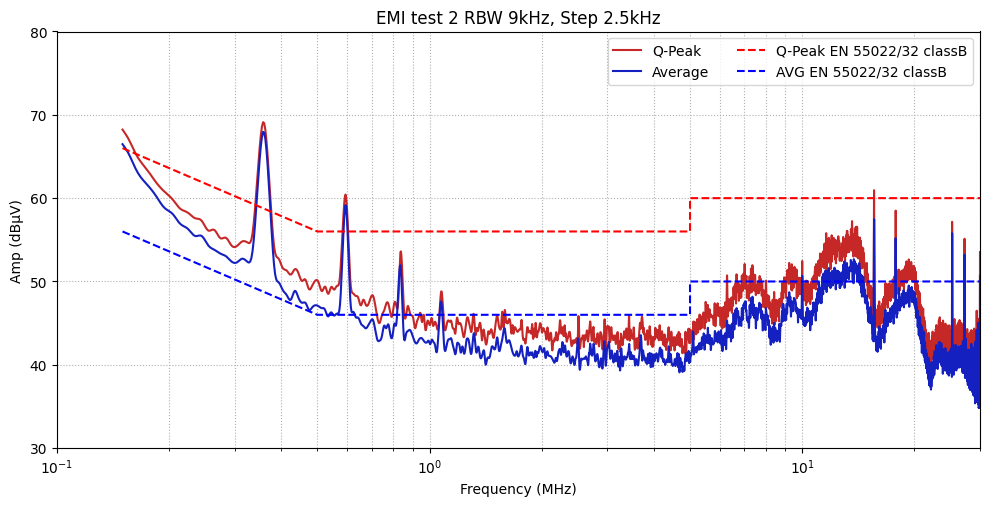

In [44]:
plt.figure(figsize=(10,5))

plt.semilogx(freqs*1e-6, qpeak, label='Q-Peak', color='#C62828')  # slightly lighter red
plt.semilogx(freqs*1e-6, avg,   label='Average', color='#1520c0')  # slightly lighter blue

# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Q-Peak EN 55022/32 classB', c="r",linestyle="--")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG EN 55022/32 classB', c= "b",linestyle="--")
plt.ylim([30,80])
plt.grid(True, which='both', ls=':')
plt.xlabel('Frequency (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amp (dBµV)')
plt.legend(ncol=2)
plt.tight_layout()
plt.title(title)
plt.show()